# Text classification with an RNN

## Setup

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Bidirectional, Embedding
from keras.callbacks import ModelCheckpoint

import torch
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.models as models

Import `matplotlib` and create a helper function to plot graphs:

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline

In [ ]:
file_path = ''

def load_data():
    train_df = pd.read_csv(file_path + 'train.csv')
    test_df = pd.read_csv(file_path + 'test.csv')
    return train_df, test_df

In [ ]:
train_df, test_df = load_data()
data_size = len(train_df)
print(data_size)

train_df = train_df[train_df.category != 'Free Gifts']
data_size = len(train_df)
print(data_size)

categories = train_df.category.unique()
category_d = {k: v for v, k in enumerate(categories)}

assert(len(categories) == 26)

train_df.replace(
    {'category': category_d}
    , inplace=True
)

# testing data

test_df.replace(
    {'category': category_d}
    , inplace=True
)

21627
21566


In [ ]:
print(train_df)

          id  ...                               noisyTextDescription
0      36274  ...  Femella Women Ankle-Length Grey AQ-S800WD-1EVD...
1      15129  ...              Converse Unisex Casual Skirts Slipper
2      58976  ...                          Velia Women Acetone Kurta
3      32922  ...                  Enroute Men Leather Brown Sandals
4      29561  ...              Aneri Exclusive Anu Pink Inspirartion
...      ...  ...                                                ...
21622   5435  ...                    SHE-3802D-1ADR Men Black Briefs
21623  27880  ...                 Adipower & Taylor Men Brown Quince
21624  38385  ...                             Rocia Women R348 Flats
21625  34853  ...                  Fastrack Men Black Amethyst Watch
21626  41407  ...             Arrow Ghicha Men White Slim Surf Shirt

[21566 rows x 7 columns]


In [ ]:
text_target = train_df[['noisyTextDescription', 'category']].values

print(text_target)

splits = np.array_split(text_target, 5)

train_data1 = np.concatenate(np.delete(splits, 4, 0))
validation_data1 = splits[4]

train_data2 = np.concatenate(np.delete(splits, 3, 0))
validation_data2 = splits[3]

train_data3 = np.concatenate(np.delete(splits, 2, 0))
validation_data3 = splits[2]

train_data4 = np.concatenate(np.delete(splits, 1, 0))
validation_data4 = splits[1]

train_data5 = np.concatenate(np.delete(splits, 0, 0))
validation_data5 = splits[0]


train_x1 = train_data1[:,0]
train_y1 = train_data1[:,1].astype(np.int64)
validation_x1 = validation_data1[:,0]
validation_y1 = validation_data1[:,1].astype(np.int64)

train_x2 = train_data2[:,0]
train_y2 = train_data2[:,1].astype(np.int64)
validation_x2 = validation_data2[:,0]
validation_y2 = validation_data2[:,1].astype(np.int64)

train_x3 = train_data3[:,0]
train_y3 = train_data3[:,1].astype(np.int64)
validation_x3 = validation_data3[:,0]
validation_y3 = validation_data3[:,1].astype(np.int64)

train_x4 = train_data4[:,0]
train_y4 = train_data4[:,1].astype(np.int64)
validation_x4 = validation_data4[:,0]
validation_y4 = validation_data4[:,1].astype(np.int64)

train_x5 = train_data5[:,0]
train_y5 = train_data5[:,1].astype(np.int64)
validation_x5 = validation_data5[:,0]
validation_y5 = validation_data5[:,1].astype(np.int64)

[['Femella Women Ankle-Length Grey AQ-S800WD-1EVDFAD170' 0]
 ['Converse Unisex Casual Skirts Slipper' 1]
 ['Velia Women Acetone Kurta' 2]
 ...
 ['Rocia Women R348 Flats' 6]
 ['Fastrack Men Black Amethyst Watch' 7]
 ['Arrow Ghicha Men White Slim Surf Shirt' 2]]


In [ ]:
VOCAB_SIZE= 2048
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)


#encoder = tf.keras.layers.experimental.preprocessing.TextVectorization()
#    max_tokens=VOCAB_SIZE)
encoder.adapt(np.concatenate([train_df.noisyTextDescription.values, test_df.noisyTextDescription.values]))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
print(len(vocab))
vocab[:20]

2048


array(['', '[UNK]', 'men', 'women', 'black', 'blue', 'tshirt', 'white',
       'shoes', 'printed', 'brown', 'red', 'grey', 'mens', 'shirt',
       'green', 'nike', 'watch', 'casual', 'adidas'], dtype='<U17')

In [ ]:
print(vocab[:200])

['' '[UNK]' 'men' 'women' 'black' 'blue' 'tshirt' 'white' 'shoes'
 'printed' 'brown' 'red' 'grey' 'mens' 'shirt' 'green' 'nike' 'watch'
 'casual' 'adidas' 'puma' 'of' 'unisex' 'navy' 'pink' 'kurta' 'dial'
 'polo' 'top' 'purple' 'united' 'sports' 'shoe' 'benetton' 'colors'
 'solid' 'handbag' 'check' 'sunglasses' 'tshirts' 'sandals' 'silver'
 'striped' 'and' 'boys' 'shirts' 'yellow' 'wallet' 'kids' 'flip' 'girls'
 'formal' 'catwalk' 'beige' 'jony' 'arrow' 'belt' 'gini' 'socks'
 'fabindia' 'fastrack' 'wrangler' 'stripes' 'perros' 'jeans' 'lino'
 'baggit' 'flats' 'flops' 'bag' 'taylor' 'backpack' 'pack' 'lee' 'perfume'
 'maroon' 'leather' 'orange' 'womens' 'fila' 'briefs' 'shorts' 'myntra'
 'heels' 'dress' 'bra' 'trousers' 'scullers' 'jealous' 'classic' 'french'
 'olive' '21' 'gold' 'earrings' 'jockey' 'john' 'connection' 'kidswear'
 '3' 'lotto' 'multi' 'murcia' 'sari' 'machine' 'w' 'coloured' 'proline'
 'colorbar' 'set' 'england' 'basics' 'flying' 'assn' 'us' 'nation'
 'indigo' 'wildcraft

In [ ]:
batch_size = 64
epochs = 15

num_classes=26
assert(len(categories) == num_classes)

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

With the default settings, the process is not completely reversible. There are three main reasns for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

## Create the model

In [ ]:
# create a callback that will save the best model while training
save_best_model1 = ModelCheckpoint('best_text_model1', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0, save_format = 'tf')
save_best_model2 = ModelCheckpoint('best_text_model2', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0, save_format = 'tf')
save_best_model3 = ModelCheckpoint('best_text_model3', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0, save_format = 'tf')
save_best_model4 = ModelCheckpoint('best_text_model4', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0, save_format = 'tf')
save_best_model5 = ModelCheckpoint('best_text_model5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0, save_format = 'tf')

In [ ]:
model1 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=1500,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(1500)),
    tf.keras.layers.Dense(700, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(num_classes)
])

model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=1500,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(1500)),
    tf.keras.layers.Dense(700, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes)
])

model3 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=1500,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(1500)),
    tf.keras.layers.Dense(700, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes)
])

model4 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=1500,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(1500)),
    tf.keras.layers.Dense(700, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes)
])

model5 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=1500,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(1500)),
    tf.keras.layers.Dense(700, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

Compile the Keras model to configure the training process:

In [ ]:
model1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(9e-5),
              metrics=['accuracy'])

model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(9e-5),
              metrics=['accuracy'])

model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(9e-5),
              metrics=['accuracy'])

model4.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(9e-5),
              metrics=['accuracy'])

model5.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(9e-5),
              metrics=['accuracy'])

## Train the model

In [ ]:
print("Fit model on training data")
history1 = model1.fit(
    train_x1,
    train_y1,
    batch_size=batch_size,
    epochs=epochs,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(validation_x1, validation_y1),
    callbacks=[save_best_model1]
)

history2 = model2.fit(
    train_x2,
    train_y2,
    batch_size=batch_size,
    epochs=epochs,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(validation_x2, validation_y2),
    callbacks=[save_best_model2]
)

history3 = model3.fit(
    train_x3,
    train_y3,
    batch_size=batch_size,
    epochs=epochs,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(validation_x3, validation_y3),
    callbacks=[save_best_model3]
)

history4 = model4.fit(
    train_x4,
    train_y4,
    batch_size=batch_size,
    epochs=epochs,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(validation_x4, validation_y4),
    callbacks=[save_best_model4]
)


history5 = model5.fit(
    train_x5,
    train_y5,
    batch_size=batch_size,
    epochs=epochs,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(validation_x5, validation_y5),
    callbacks=[save_best_model5]
)

Fit model on training data
Epoch 1/15
270/270 [==============================] - ETA: 0s - loss: 0.9611 - accuracy: 0.7935WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: best_text_model1/assets
270/270 [==============================] - 37s 135ms/step - loss: 0.9611 - accuracy: 0.7935 - val_loss: 1.8030 - val_accuracy: 0.9059
Epoch 2/15
270/270 [==============================] - 37s 138ms/step - loss: 0.3965 - accuracy: 0.9091 - val_loss: 0.4225 - val_accuracy: 0.9114
Epoch 3/15
270/270 [==============================] - 37s 137ms/step

In [ ]:
'''test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))'''

"test_loss, test_acc = model.evaluate(test_dataset)\n\nprint('Test Loss: {}'.format(test_loss))\nprint('Test Accuracy: {}'.format(test_acc))"

(0.0, 1.5208459351211787)

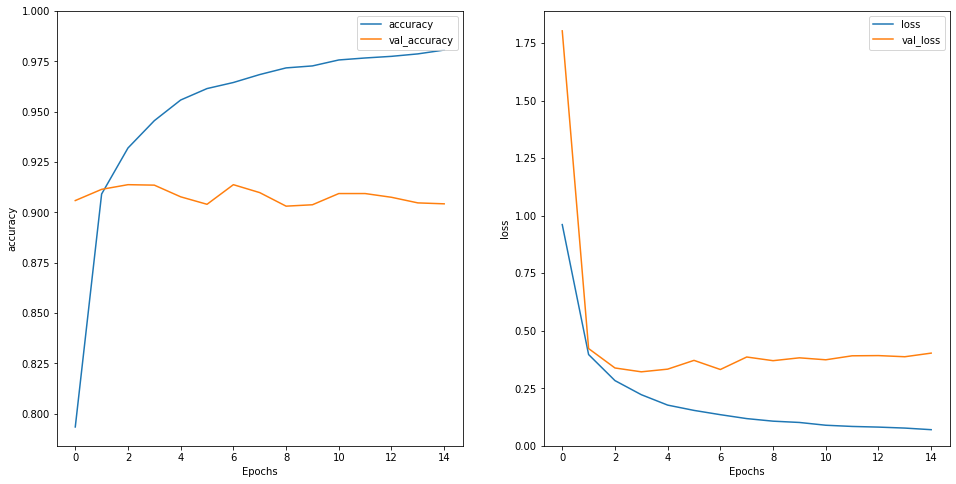

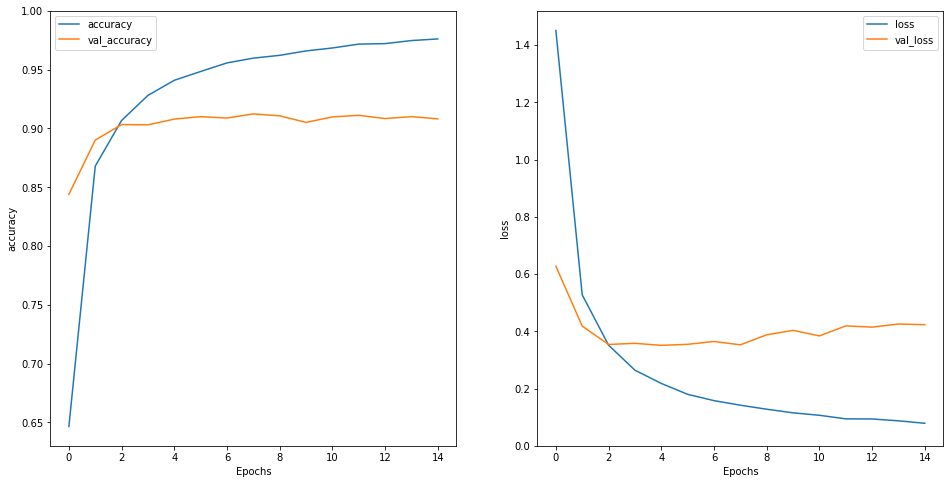

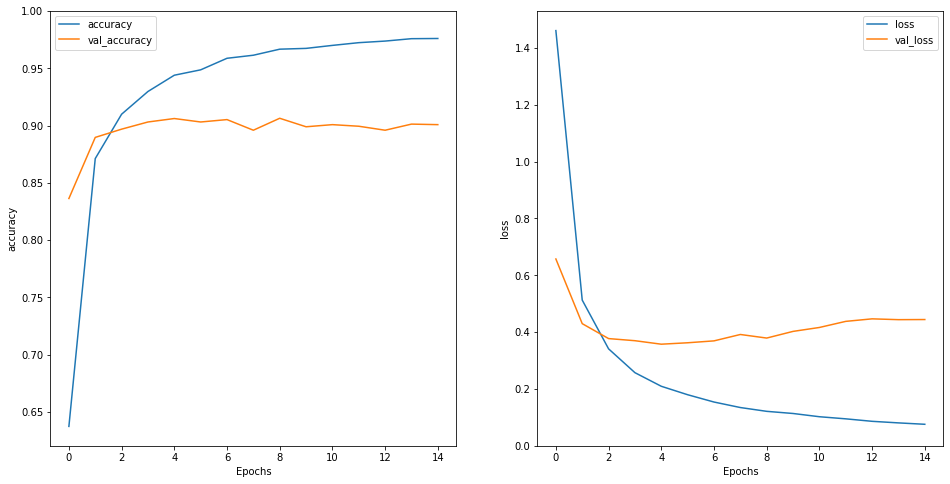

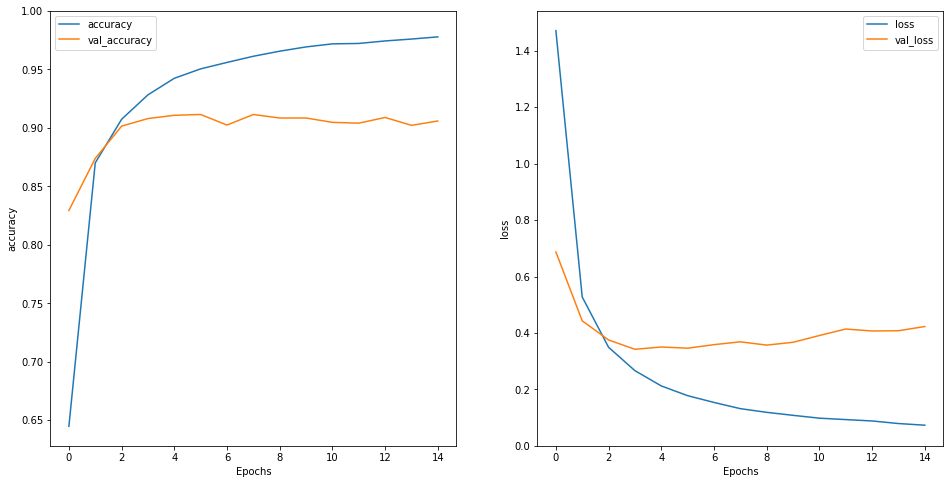

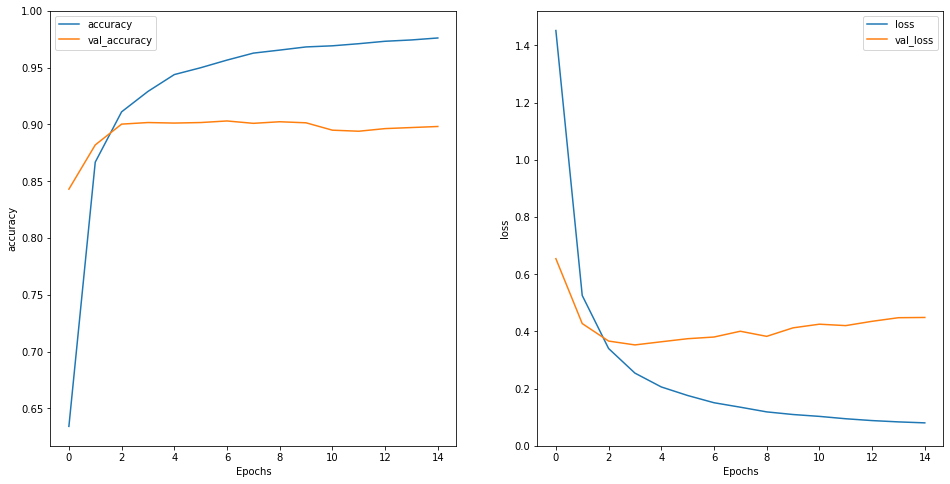

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history1, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history1, 'loss')
plt.ylim(0,None)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history2, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history2, 'loss')
plt.ylim(0,None)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history3, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history3, 'loss')
plt.ylim(0,None)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history4, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history4, 'loss')
plt.ylim(0,None)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history5, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history5, 'loss')
plt.ylim(0,None)

In [ ]:
test_text = test_df['noisyTextDescription'].values

model1 = load_model('best_text_model1')
model2 = load_model('best_text_model2')
model3 = load_model('best_text_model3')
model4 = load_model('best_text_model4')
model5 = load_model('best_text_model5')

pred1 = model1.predict(test_text)
pred2 = model2.predict(test_text)
pred3 = model3.predict(test_text)
pred4 = model4.predict(test_text)
pred5 = model5.predict(test_text)

prob1 = torch.tensor(pred1)
prob2 = torch.tensor(pred2)
prob3 = torch.tensor(pred3)
prob4 = torch.tensor(pred4)
prob5 = torch.tensor(pred5)

torch.save(prob1, 'prob1_text.pt')
torch.save(prob2, 'prob2_text.pt')
torch.save(prob3, 'prob3_text.pt')
torch.save(prob4, 'prob4_text.pt')
torch.save(prob5, 'prob5_text.pt')

prob_result = (nn.Softmax(dim=1)(prob1) + nn.Softmax(dim=1)(prob2) + nn.Softmax(dim=1)(prob3)
                       + nn.Softmax(dim=1)(prob4) + nn.Softmax(dim=1)(prob5))

torch.save(torch.tensor(prob_result), 'prob_result_text.pt')

prediction1 = prob_result.argmax(dim=1)

test_df['category'] = categories[torch.flatten(prediction1).numpy()]

headers = ['id', 'category']

result = test_df[headers].values

predict = pd.DataFrame(result, columns=headers)

print(predict)

predict.to_csv('submission_text.csv', index=False)

          id   category
0      26266  Innerwear
1      22134    Topwear
2      28358    Wallets
3      15554      Shoes
4      53408  Innerwear
...      ...        ...
21623  39737    Eyewear
21624  57477      Dress
21625  22312    Topwear
21626  54105       Lips
21627  14080       Bags

[21628 rows x 2 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
!ls

best_text_model1  best_text_model5  prob4_text.pt	 submission_text.csv
best_text_model2  prob1_text.pt     prob5_text.pt	 test.csv
best_text_model3  prob2_text.pt     prob_result_text.pt  train.csv
best_text_model4  prob3_text.pt     sample_data


In [ ]:
!zip -r best_text_model1.zip best_text_model1
!zip -r best_text_model2.zip best_text_model2
!zip -r best_text_model3.zip best_text_model3
!zip -r best_text_model4.zip best_text_model4
!zip -r best_text_model5.zip best_text_model5

  adding: best_text_model1/ (stored 0%)
  adding: best_text_model1/variables/ (stored 0%)
  adding: best_text_model1/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: best_text_model1/variables/variables.index (deflated 67%)
  adding: best_text_model1/saved_model.pb (deflated 89%)
  adding: best_text_model1/assets/ (stored 0%)
  adding: best_text_model2/ (stored 0%)
  adding: best_text_model2/variables/ (stored 0%)
  adding: best_text_model2/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: best_text_model2/variables/variables.index (deflated 65%)
  adding: best_text_model2/saved_model.pb (deflated 89%)
  adding: best_text_model2/assets/ (stored 0%)
  adding: best_text_model3/ (stored 0%)
  adding: best_text_model3/variables/ (stored 0%)
  adding: best_text_model3/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: best_text_model3/variables/variables.index (deflated 65%)
  adding: best_text_model3/saved_model.pb (deflated 89%)
  adding: best_tex